In [1]:
from bioformers.datasets.ArrowDataset import ArrowDataset
from bioformers.datasets import dataset_utils
from bioformers.utilize.Bert import BertSeqClassification
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
import os
import numpy
import warnings 

from transformers import BertModel, BertTokenizer
import re

from datasets import load_dataset
from datasets import Dataset
from datasets import load_from_disk
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import torch


os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["MKL_THREADING_LAYER"] = "GNU"
os.environ["TOKENIZERS_PARALLELISM"] = "true"


num_cpu = 16
max_length = 512
lr = '1.81e-5'
num_labels = 2
max_epch = 21
gpu = '3'
min_lr = float(1e-13)
max_lr = float(0.000000000005)

encoded_csv = "/mnt/storage/grid/home/eric/hmm2bert/data_prep/onlyFunctional_encoded_labels_ketosynthase.csv"

saved_strat_train = "/mnt/storage/grid/home/eric/hmm2bert/data_prep/ketosynthase_classify_domain_strat_train.pt"
saved_strat_val = "/mnt/storage/grid/home/eric/hmm2bert/data_prep/ketosynthase_classify_domain_strat_val.pt"

In [2]:
# load tokenizer and wandb logger

wandb_logger = WandbLogger(name=f"classify_domain-{lr}", project="hmm_reBERT")

tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)
#model = BertModel.from_pretrained("Rostlab/prot_bert")



In [3]:
# load encoded label csv to huggingface dataset AND pandas dataframe
dataset = load_dataset('csv', data_files=encoded_csv)
df = pd.read_csv(encoded_csv)
dataset1 = dataset['train']
print(dataset1.column_names)
print("")
print(df.head())
print(df.tail())

Using custom data configuration default-81807439c898b100


Dataset csv downloaded and prepared to /home/eric/.cache/huggingface/datasets/csv/default-81807439c898b100/0.0.0/2a88c45fed596f9421a2e7f74ab1a3cd012ef75210a5dc1950e8d60ca8d9c66c. Subsequent calls will reuse this data.
['sequence_ID', 'sequences', 'labels']

   sequence_ID                                          sequences  labels
0   3149483402  A I V G V S G R Y P M A D T L E E F W Q N L R ...       0
1     21815241  A I I G L S G R Y P E A H D L T A F W S N L A ...       0
2   3255460296  A I I G M S G R Y P Q A R T V E Q L W D N L L ...       0
3   1492575639  A I V G M A G R F P G A D S L E T F W Q N L V ...       0
4     50818899  A V I G M S G R F P K S A D L N E L W E H L H ...       0
     sequence_ID                                          sequences  labels
917   1206469164  A V V G M A A R Y A D A E D P R A L W D H L M ...       1
918    930116041  A I I G M S G R F P G A R N V D E L W T I L R ...       1
919   4228394525  A I I G V A V R C G G A R N Q R E L W E L V R ...   

In [4]:
# separate dataset into training and validation based on 'Labels' column in dataset

num_rows_list = list(range(len(dataset1)))
strat_train, strat_test = train_test_split(num_rows_list, stratify=dataset1['labels'], random_state=420)

print(len(strat_train))
print(len(strat_test))

691
231


In [5]:
#pass strat_train and strat_test into bioformers encoding function

strat_train_dataset = dataset_utils.encode_dataset(
    subset=Dataset.from_pandas(df.iloc[strat_train]),
    tokenizer=tokenizer,
    key="sequences",
    include_labels=True,
    padding="max_length",
    max_length=512,
    truncation=True
)

strat_train_dataset1 = strat_train_dataset.remove_columns(['sequence_ID', '__index_level_0__'])

torch.save(strat_train_dataset1, saved_strat_train)

strat_test_dataset = dataset_utils.encode_dataset(
    subset=Dataset.from_pandas(df.iloc[strat_test]),
    tokenizer=tokenizer,
    key="sequences",
    include_labels=True,
    padding="max_length",
    max_length=512,
    truncation=True
)

strat_test_dataset1 = strat_test_dataset.remove_columns(['sequence_ID', '__index_level_0__'])

torch.save(strat_test_dataset1, saved_strat_val)

remove_columns_ is deprecated and will be removed in the next major version of datasets. Use the dataset.remove_columns method instead.


# ===========================================================

In [3]:
#load train and test tensors and instantiate pytorch lightning wrapper for the huggingface model with the base pretrained protbert model

encoded_train = torch.load(saved_strat_train)
encoded_test = torch.load(saved_strat_val)

bsc = BertSeqClassification(pretrained_dir="Rostlab/prot_bert", use_adafactor=True, num_labels=num_labels)

Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initiali

In [4]:
# setup data collator, trainer, and dataloader for train and test dataset

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    max_epochs=max_epch,
    gpus=gpu,
    auto_lr_find=False,
    logger=wandb_logger
)

warnings.filterwarnings("ignore")

train_dl = DataLoader(encoded_train, batch_size=4, num_workers=num_cpu, collate_fn=data_collator, shuffle=True)
eval_dl = DataLoader(encoded_test, batch_size=4, num_workers=num_cpu, collate_fn=data_collator, shuffle=False)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [5]:
lr_finder = trainer.tuner.lr_find(bsc, train_dataloader=train_dl, min_lr=min_lr, max_lr=max_lr, num_training=100, mode='exponential', early_stop_threshold=4)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name | Type                          | Params
-------------------------------------------------------
0 | bert | BertForSequenceClassification | 419 M 
-------------------------------------------------------
419 M     Trainable params
0         Non-trainable params
419 M     Total params
1,679.733 Total estimated model params size (MB)


Restored states from the checkpoint file at /mnt/storage/grid/home/eric/hmm2bert/lr_find_temp_model.ckpt


In [6]:
lr_finder.results

{'lr': [1e-13,
  1.0813826568002934e-13,
  1.1245249616419848e-13,
  1.1693884504284608e-13,
  1.2160417906586574e-13,
  1.2645563893559071e-13,
  1.315006502362645e-13,
  1.367469347995477e-13,
  1.4220252252345783e-13,
  1.4787576366283139e-13,
  1.5377534161012037e-13,
  1.5991028618608487e-13,
  1.6628998746072466e-13,
  1.7292421012560372e-13,
  1.798231084395659e-13,
  1.869972417707175e-13,
  1.94457590758465e-13,
  2.0221557412034526e-13,
  2.1028306612937304e-13,
  2.1867241478865562e-13,
  2.273964607310932e-13,
  2.3646855687309215e-13,
  2.459025888523731e-13,
  2.5571299628115565e-13,
  2.6591479484724944e-13,
  2.7652359929687964e-13,
  2.8755564733442355e-13,
  2.9902782447563943e-13,
  3.1095768989242706e-13,
  3.2336350328867867e-13,
  3.3626425284835454e-13,
  3.496796842985618e-13,
  3.636303311321192e-13,
  3.7813754603586656e-13,
  3.9322353357282144e-13,
  4.0891138416820855e-13,
  4.2522510945137703e-13,
  4.421896790077027e-13,
  4.598310585967256e-13,
  4.78176

In [7]:
torch.cuda.empty_cache

<function torch.cuda.memory.empty_cache()>

# =====LR Finder=====

In [ ]:
fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print("suggested lr: " + str(new_lr)) #0.0001 max, 1e-13 min, lowest 3.1084745275846952
print("min lr: " + str(min_lr))
print("max lr: " + str(max_lr))


3.388441561392026e-12


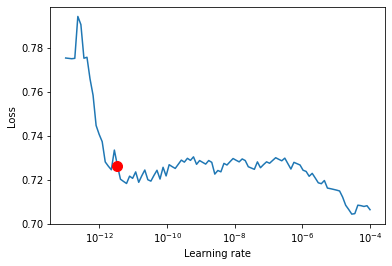

In [7]:
fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print(new_lr) #0.0001 max, 1e-13 min, lowest 3.1084745275846952


4.786300923226383e-12


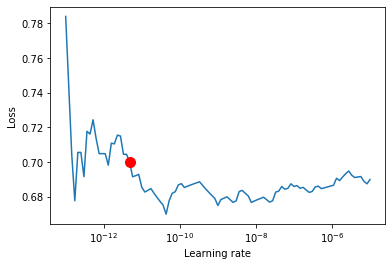

In [7]:
fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print(new_lr) #0.00001 max, 1e-13 min, lowest 0.72381674574446


4.073802778041128e-12


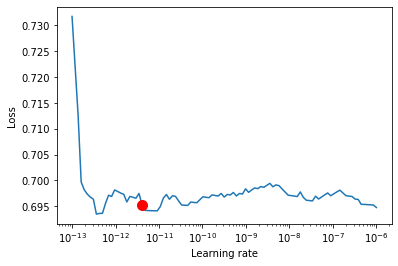

In [7]:
fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print(new_lr) #0.000001 max, 1e-13 min, lowest 0.72381674574446


4.168693834703355e-12


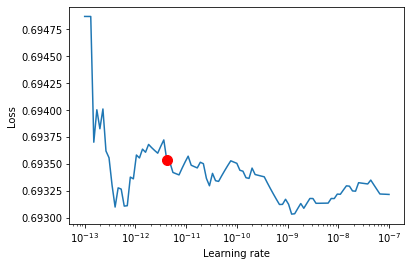

In [7]:
fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print(new_lr) #0.0000001 max, 1e-13 min, lowest 0.72381674574446


2.511886431509581e-12


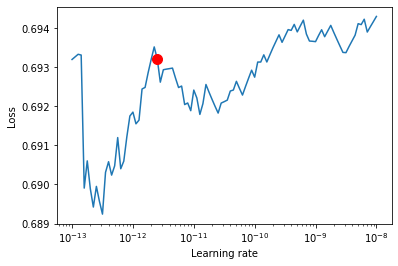

In [7]:
fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print(new_lr) #0.00000001 max, 1e-13 min, lowest 0.72381674574446


5.248074602497726e-13


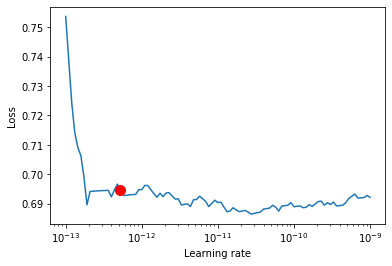

In [8]:
fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print(new_lr) #0.000000001 max, 1e-13 min, lowest 0.72381674574446


2.1379620895022323e-13


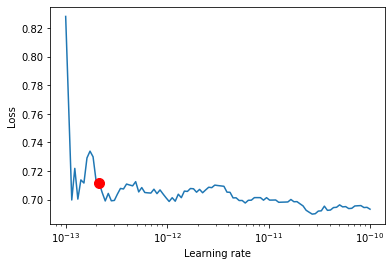

In [7]:
fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print(new_lr) #0.0000000001 max, 1e-13 min, lowest 0.72381674574446


1.7378008287493754e-13


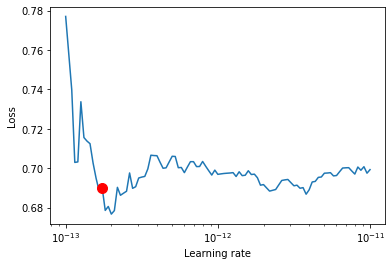

In [7]:
fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print(new_lr) #0.00000000001 max, 1e-13 min, lowest 0.72381674574446


1.045639552591273e-12


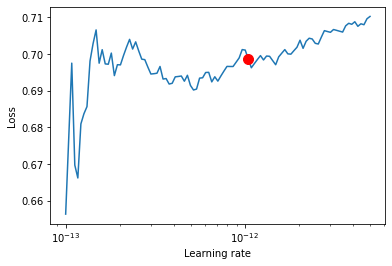

In [7]:
fig = lr_finder.plot(suggest=True)###
fig.show()

new_lr = lr_finder.suggestion()
print(new_lr) #0.000000000001 max, 1e-13 min, lowest 0.72381674574446


0.00012570133745218285


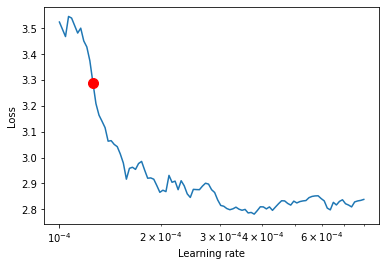

In [7]:
fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print(new_lr) #0.0008 max, 1e-04 min, lowest 2.781522015577493


0.0001365261006415074


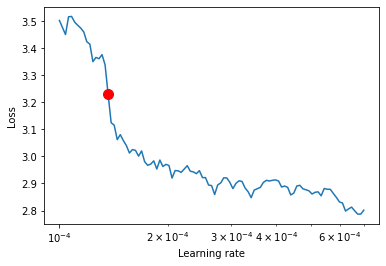

In [7]:
fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print(new_lr) #0.0007 max, 1e-04 min, lowest 2.78686541325872



0.00013146946654753934


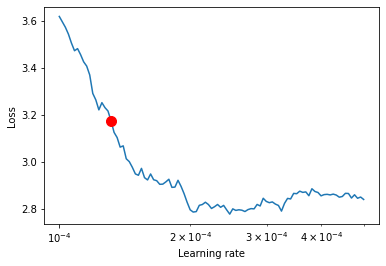

In [7]:
fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print(new_lr) #0.0005 max, 1e-04 min, lowest 2.7770565032470316



0.0001


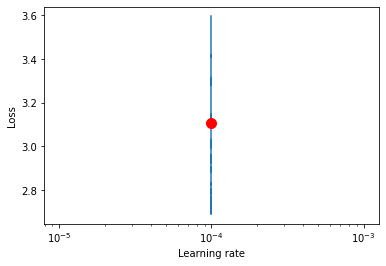

In [7]:
fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print(new_lr) #0.0007 max, 1e-04 min, lowest 2.78686541325872



0.0001259492145542903


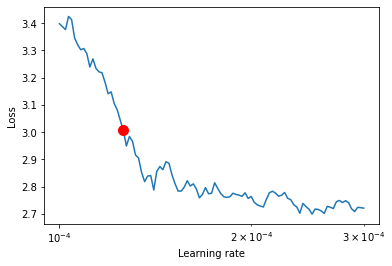

In [7]:
fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print(new_lr) #0.0003 max, 1e-04 min, lowest 2.6990322614065985
#1e-8.979

In [ ]:
fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print(new_lr) #0.0007 max, 1e-04 min, lowest 2.78686541325872


In [ ]:
fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print(new_lr) #0.0007 max, 1e-04 min, lowest 2.78686541325872
